Saving datos_ventas_inf.csv to datos_ventas_inf.csv
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.1785 - val_loss: 0.2159
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0776 - val_loss: 0.1091
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0303 - val_loss: 0.0491
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0206 - val_loss: 0.0309
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0261 - val_loss: 0.0314
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0190 - val_loss: 0.0385
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0195 - val_loss: 0.0494
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0232 - val_loss: 0.0587
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0177 - val_loss: 0.0636
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0195 - val_loss: 0.0561
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0195 - val_loss: 0.0457
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0206 - val_loss: 0.0397
E

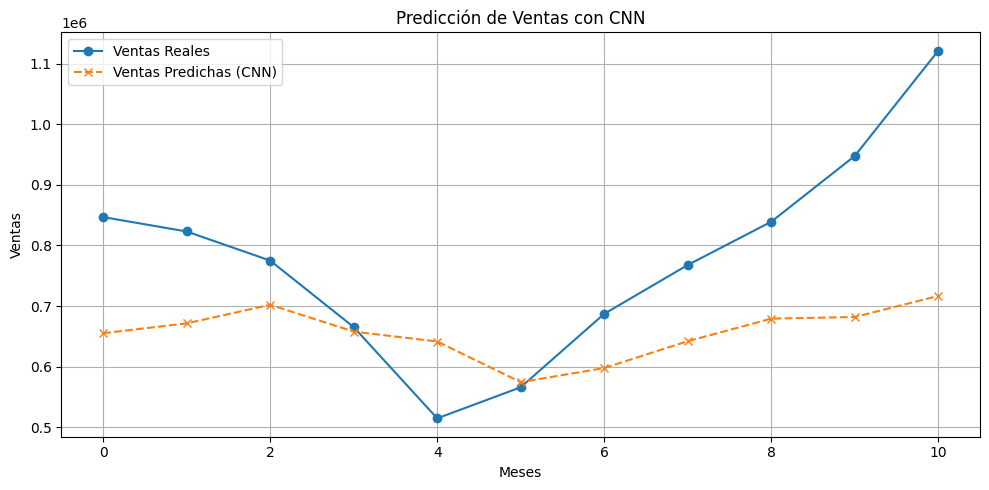

In [ ]:
import pandas as pd
from google.colab import files

# Subir archivo CSV
uploaded = files.upload()

# Leer y preparar DataFrame
df = pd.read_csv("datos_ventas_inf.csv")
df["fecha"] = pd.to_datetime(df["fecha"], format="%Y-%m")
df = df.sort_values("fecha")
df.head()
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Escalar ventas, inflación y EMAE
scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(df[["venta", "inflacion", "emae"]])

# Función para crear secuencias temporales para CNN
def crear_secuencias(data, ventana=3):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data[i-ventana:i])
        y.append(data[i, 0])  # predicción de venta
    return np.array(X), np.array(y)

ventana = 3
X, y = crear_secuencias(datos_scaled, ventana)

# Dividir en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

modelo_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

modelo_cnn.compile(optimizer='adam', loss='mse')

# Entrenar
modelo_cnn.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=1)
# Predicciones
y_pred_scaled = modelo_cnn.predict(X_test)

# Invertir la escala solo de las ventas
scaler_venta = MinMaxScaler()
scaler_venta.fit(df[["venta"]][:split + ventana])  # ventas entrenamiento + ventana

y_pred = scaler_venta.inverse_transform(y_pred_scaled)
y_real = scaler_venta.inverse_transform(y_test.reshape(-1, 1))
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_real, y_pred)
print(f"🔹 MAE (CNN, escala real): {mae:,.2f} unidades")

# Aplanar arrays por si tienen forma (n,1)
y_real = y_real.flatten()
y_pred = y_pred.flatten()

# Evitar división por cero
non_zero = y_real != 0

# Calcular MAPE
mape = np.mean(np.abs((y_real[non_zero] - y_pred[non_zero]) / y_real[non_zero])) * 100

# Calcular BIAS
bias = np.mean(y_pred - y_real)

# Mostrar resultados
print(f"🔸 MAPE (CNN): {mape:.2f}%")
print(f"🔸 BIAS (CNN): {bias:,.2f} unidades")

plt.figure(figsize=(10,5))
plt.plot(y_real, label="Ventas Reales", marker='o')
plt.plot(y_pred, label="Ventas Predichas (CNN)", linestyle="--", marker='x')
plt.title("Predicción de Ventas con CNN")
plt.xlabel("Meses")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
